# **Experiments on synthetic data**
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lealagonotte/Geometric_data_analysis_project/blob/raph-colab/experiments/main_diet.ipynb)  
See on Hugging Face: https://huggingface.co/datasets/xingjiepan/PerturbMulti

## **Colab setup**

In [1]:
!git clone https://github.com/lealagonotte/Geometric_data_analysis_project.git
%cd Geometric_data_analysis_project/
!git clone https://github.com/raphaelrubrice/Perturb-OT.git
!git checkout raph-colab

Cloning into 'Geometric_data_analysis_project'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 121 (delta 62), reused 82 (delta 29), pack-reused 0 (from 0)
Receiving objects: 100% (121/121), 2.66 MiB | 16.50 MiB/s, done.
Resolving deltas: 100% (62/62), done.
/content/Geometric_data_analysis_project
Cloning into 'Perturb-OT'...
remote: Enumerating objects: 918, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 918 (delta 16), reused 42 (delta 2), pack-reused 851 (from 2)
Receiving objects: 100% (918/918), 38.95 MiB | 19.66 MiB/s, done.
Resolving deltas: 100% (126/126), done.
M	Perturb-OT
Branch 'raph-colab' set up to track remote branch 'raph-colab' from 'origin'.
Switched to a new branch 'raph-colab'


In [2]:
!pip install -r requirements-env.txt

Processing ./Perturb-OT/ott (from -r requirements-env.txt (line 4))
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Processing ./Perturb-OT/perturbot (from -r requirements-env.txt (line 5))
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Processing ./Perturb-OT/scvi-tools (from -r requirements-env.txt (line 6))
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 3.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of equinox to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at mul

YOU WILL NEED TO RESTART THE SESSION AFTER THE PREVIOUS CELL.
After restarting you should have a working env.

Let's check that we have succesfully recreated the env

In [1]:
import sys, gc

import perturbot.match
import perturbot.predict
from perturbot.match import (
    get_coupling_cotl,
    get_coupling_cotl_sinkhorn,
    get_coupling_egw_labels_ott,
    get_coupling_egw_all_ott,
    get_coupling_eot_ott,
    get_coupling_leot_ott,
    get_coupling_egw_ott,
    get_coupling_cot,
    get_coupling_cot_sinkhorn,
    get_coupling_gw_labels,
    get_coupling_fot,
)
from perturbot.predict import train_mlp
from perturbot.eval.prediction import get_evals, get_evals_preds
from perturbot.eval.match import get_FOSCTTM_single, get_FOSCTTM
import ot
print("Imports succeeded")

Imports succeeded


## **Imports**

In [2]:
import torch

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme("paper")
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
from scanpy.preprocessing import subsample

import itertools, time, os
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split, StratifiedKFold

## **Download the data**

In [3]:
%cd Geometric_data_analysis_project/
!mkdir data
%cd data
!wget https://huggingface.co/datasets/xingjiepan/PerturbMulti/resolve/main/RNA_scaled_diet_conditions_20240411.h5ad
!wget https://huggingface.co/datasets/xingjiepan/PerturbMulti/resolve/main/protein_intensities_diet_conditions_20240411.h5ad

/content/Geometric_data_analysis_project
/content/Geometric_data_analysis_project/data
--2025-12-07 07:13:15--  https://huggingface.co/datasets/xingjiepan/PerturbMulti/resolve/main/RNA_scaled_diet_conditions_20240411.h5ad
Resolving huggingface.co (huggingface.co)... 3.165.160.59, 3.165.160.12, 3.165.160.11, ...
Connecting to huggingface.co (huggingface.co)|3.165.160.59|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://us.gcp.cdn.hf.co/xet-bridge-us/680ec5cec4756876c4befb83/97e210f08666db8f77166e12b71bdfb60cebbe3482271042fe5edce510f8ee78?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27RNA_scaled_diet_conditions_20240411.h5ad%3B+filename%3D%22RNA_scaled_diet_conditions_20240411.h5ad%22%3B&Expires=1765095195&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiRXBvY2hUaW1lIjoxNzY1MDk1MTk1fX0sIlJlc291cmNlIjoiaHR0cHM6Ly91cy5nY3AuY2RuLmhmLmNvL3hldC1icmlkZ2UtdXMvNjgwZWM1Y2VjNDc1Njg3NmM0YmVmYjgzLzk3ZTIxMGYwODY2NmRiOGY3NzE2NmUxMmI

In [4]:
%cd /content/Geometric_data_analysis_project/

/content/Geometric_data_analysis_project


## **Load & process data**

In [5]:
path_rna_diet = "./data/RNA_scaled_diet_conditions_20240411.h5ad"
rna_diet = ad.read_h5ad(path_rna_diet)

In [6]:
rna_diet.obs.head()

,fov,x,y,z,area,cond,batch
id,,,,,,,
100001368350601220443305171011375780801,717,6666.830785,7236.949846,0,296.588262,adlib,IE29
100001800432857001134785976606575060287,849,8413.609407,7209.004054,9,28.819318,adlib,IE29
100002804203690621291738422225750332629,659,6218.665741,3959.272899,6,47.580965,adlib,IE29
100003573867315829655028318295181964954,478,4796.646369,2362.160563,0,596.398900,adlib,IE29
100008668971788868972348129958710863790,885,8984.942123,4629.471220,3,31.794475,adlib,IE29


In [7]:
path_prot_diet = "./data/protein_intensities_diet_conditions_20240411.h5ad"
prot_diet = ad.read_h5ad(path_prot_diet)

In [8]:
prot_diet.obs.head()

,cell_id,condition,cell_name,fov,x,y,z,area,cond,batch,n_genes,n_counts,datatype,leiden,new_leiden,new_leiden_relabeled,cell_type,cluster_type,cell_type_color,cluster_type_color
0,0,adlib_T cell,92741088075053779116951994856866301126,631,10487.513193,125.414363,1,288.918642,adlib,2,79,409.0,merfish,16,2,5,T cell,T cell,8,15
1,1,adlib_T cell,133524280519918220907967806861786402321,847,8363.706168,6825.614590,0,342.417939,adlib,1,49,184.0,merfish,16,2,5,T cell,T cell,8,15
2,2,adlib_T cell,116603158813595984705504213443274415416,781,12026.084383,855.943716,4,52.808116,adlib,2,30,113.0,merfish,16,2,5,T cell,T cell,8,15
3,3,adlib_T cell,317866311329856700012086944685408447975,272,3096.611149,2092.912335,5,123.233572,adlib,1,63,292.0,merfish,16,2,5,T cell,T cell,8,15
4,4,adlib_T cell,150257798544309436723007524508073422512,654,6152.449135,7133.888484,0,96.995168,adlib,1,24,53.0,merfish,16,2,5,T cell,T cell,8,15


In [9]:
GENES = list(rna_diet.var.index)
PROTEINS = list(prot_diet.var.index)
CONDITIONS = list(np.unique(rna_diet.obs['cond']))

In [10]:
print(f"Number of Genes: {len(GENES)}")
print(f"Number of Proteins: {len(PROTEINS)}")
print(f"Number of conditions: {len(CONDITIONS)} ({CONDITIONS})")

Number of Genes: 260
Number of Proteins: 18
Number of conditions: 3 (['adlib', 'fasted', 'hfd'])


In [11]:
print("Maximum expression", np.max(rna_diet.X))
print("Minimum expression", np.min(rna_diet.X))

Maximum expression 10.0
Minimum expression -0.7879467953842848


In [12]:
print("Maximum intensity", np.max(prot_diet.X))
print("Minimum intensity", np.min(prot_diet.X))

Maximum intensity nan
Minimum intensity nan


In [13]:
print("There are nans:", np.isnan(prot_diet.X).sum())

There are nans: 36


In [14]:
nan_mask_rowise = np.where(np.isnan(prot_diet.X).sum(axis=1) > 0, True, False)
print(f"These nans come from {nan_mask_rowise.sum()} rows")
prot_diet.X[nan_mask_rowise,:]

These nans come from 2 rows


array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan]])

Let's remove these rows

In [15]:
prot_diet_noNA = prot_diet[~nan_mask_rowise,:]
print("Maximum intensity", np.max(prot_diet_noNA.X))
print("Minimum intensity", np.min(prot_diet_noNA.X))

Maximum intensity 0.8667076230049133
Minimum intensity 0.004974730312824249


In [16]:
prot_diet.obs["cond"].value_counts() / prot_diet.shape[0]

,count
cond,
adlib,0.352573
fasted,0.329616
hfd,0.317811


In [17]:
rna_diet.obs["cond"].value_counts() / rna_diet.shape[0]

,count
cond,
adlib,0.364393
fasted,0.322702
hfd,0.312905


All three diets are quite well balanced in the dataset.  
For the remaining cells we will use a subset of the data where only a fraction of cells of each conditions are used for speed purposes.

In [18]:
def condition_subsample(adata, frac, cond_col):
    all_conditions = np.unique(adata.obs[cond_col])
    adata_list = []
    for cond in all_conditions:
        cond_adata = adata[adata.obs[cond_col] == cond]
        adata_list.append(subsample(cond_adata,frac,copy=True))
    return ad.concat(adata_list, axis=0)

FRAC = 0.01

In [19]:
sub_rna_diet = condition_subsample(rna_diet, FRAC, 'cond')
sub_rna_diet

AnnData object with n_obs × n_vars = 7404 × 260
    obs: 'fov', 'x', 'y', 'z', 'area', 'cond', 'batch'

In [20]:
del rna_diet
gc.collect()

555

In [21]:
sub_prot_diet = condition_subsample(prot_diet, FRAC, 'cond')
sub_prot_diet

AnnData object with n_obs × n_vars = 5009 × 18
    obs: 'cell_id', 'condition', 'cell_name', 'fov', 'x', 'y', 'z', 'area', 'cond', 'batch', 'n_genes', 'n_counts', 'datatype', 'leiden', 'new_leiden', 'new_leiden_relabeled', 'cell_type', 'cluster_type', 'cell_type_color', 'cluster_type_color'

In [22]:
del prot_diet
gc.collect()

414

We can check that condition proportions are respected

In [23]:
sub_rna_diet.obs['cond'].value_counts() / sub_rna_diet.shape[0]

,count
cond,
adlib,0.364398
fasted,0.322663
hfd,0.312939


In [24]:
sub_prot_diet.obs['cond'].value_counts() / sub_prot_diet.shape[0]

,count
cond,
adlib,0.352565
fasted,0.329607
hfd,0.317828


## **Visualize data**

Great, now let's visualize our data with UMAP

In [57]:
def pca_data(adata):
    # Computing reduced dimension
    print("Reducing dimension..")
    sc.tl.pca(adata, n_comps=20)
    print("Plotting PCA Variance ratios..")
    sc.pl.pca_variance_ratio(adata, n_pcs=20, log=False)

def plot_umap(adata, cond_col,
              reduce_data=True,
              n_neighbors=15,
              metric='euclidean',
              min_dist=0.1,
              spread=1.0,
              addon=''):
    if reduce_data:
        pca_data(adata)
    # Obtain neighbors
    print("Obtaining neighbors..")
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, metric=metric)
    # Compute umap
    print("Computing UMAP..")
    sc.tl.umap(adata, min_dist=min_dist, spread=spread)
    # Plot
    print("Plotting..")
    sc.pl.umap(adata,
               color=cond_col,
               title=f"Dataset ({addon} modality) colored by diet condition",
               save=f"Our_UMAP_Diet_{addon}.pdf")

Reducing dimension..
Plotting PCA Variance ratios..


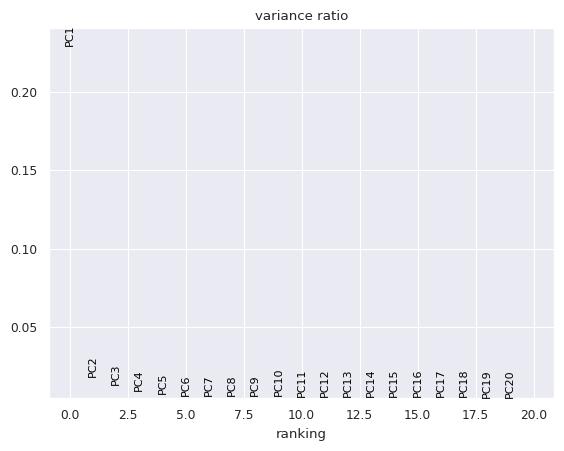

Obtaining neighbors..
Computing UMAP..
Plotting..


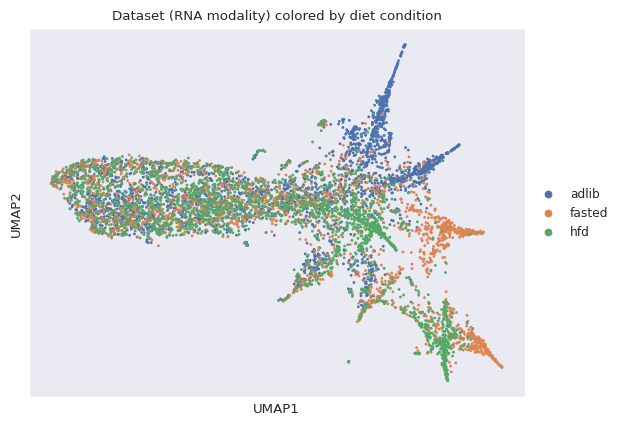

In [58]:
plot_umap(sub_rna_diet, 'cond',
          reduce_data=True,
          n_neighbors=15,
          metric='euclidean',
          min_dist=0.1,
          spread=1.0,
          addon='RNA')

In [59]:
sub_rna_diet

AnnData object with n_obs × n_vars = 7404 × 260
    obs: 'fov', 'x', 'y', 'z', 'area', 'cond', 'batch'
    uns: 'pca', 'neighbors', 'umap', 'cond_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [60]:
sub_rna_diet.obsm['X_pca'].shape

(7404, 20)

Obtaining neighbors..
Computing UMAP..
Plotting..


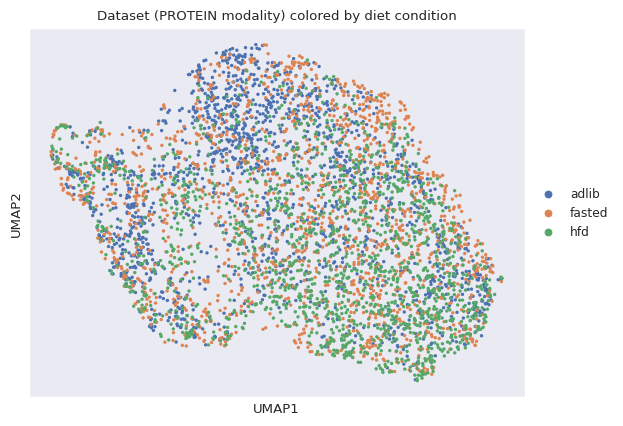

In [61]:
plot_umap(sub_prot_diet, 'cond',
          reduce_data=False,
          n_neighbors=15,
          metric='euclidean',
          min_dist=0.1,
          spread=1.0,
          addon='PROTEIN')

In [62]:
sub_prot_diet

AnnData object with n_obs × n_vars = 5009 × 18
    obs: 'cell_id', 'condition', 'cell_name', 'fov', 'x', 'y', 'z', 'area', 'cond', 'batch', 'n_genes', 'n_counts', 'datatype', 'leiden', 'new_leiden', 'new_leiden_relabeled', 'cell_type', 'cluster_type', 'cell_type_color', 'cluster_type_color'
    uns: 'neighbors', 'umap', 'cond_colors'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

We clearly do not have a UMAP space as good as the authors, we need to find better UMAP hyperparameters in hope of identifying a good combination to visualize our data.

In [30]:
def grid_search_umap(adata):
    n_neighbors_list = [15, 50, 100]
    min_dist_list = [0.01, 0.1, 0.3, 0.5]
    spread_list = [0.5, 1.0, 1.5, 10]
    metrics = ['euclidean']

    # Create all combinations
    param_grid = list(itertools.product(n_neighbors_list, min_dist_list, spread_list, metrics))

    # Run grid search
    for i, (n_neighbors, min_dist, spread, metric) in tqdm(enumerate(param_grid), total=len(param_grid)):
        print(f"Running UMAP with n_neighbors={n_neighbors}, min_dist={min_dist}, spread={spread}, metric={metric}")

        try:
            plot_umap(
                sub_rna_diet,
                'cond',
                reduce_data=False,
                n_neighbors=n_neighbors,
                metric=metric,
                min_dist=min_dist,
                spread=spread
            )
        except Exception as e:
            print(f"Failed with: {e}")

I ran it, it took about 30 min on my device but it revealed that none of the proposed combinations really helped. I suspect that the apparent structure at ~5k cells could be much different than that with the whole dataset.

In [31]:
# grid_search_umap(sub_rna_diet)

In [32]:
# grid_search_umap(sub_prot_diet)

## **Cross-Validation splits**

In [33]:
def create_stratified_folds(
    adata: ad.AnnData,
    n_splits: int = 5,
    label_key: str = "cond",
    random_state: int = 1234,
):
    """
    Create stratified CV folds for a single AnnData object.

    Parameters
    ----------
    adata : AnnData
        AnnData object to split.
    n_splits : int
        Number of CV folds.
    label_key : str
        Column in .obs used for stratification (e.g. "cond").
    random_state : int
        Random seed for reproducible splits.

    Returns
    -------
    folds : list of dict
        Each dict contains:
        - "fold": int
        - "train_idx": np.ndarray
        - "test_idx": np.ndarray
    """
    labels = np.array(adata.obs[label_key])
    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state,
    )

    folds = []
    for fold_id, (train_idx, test_idx) in enumerate(skf.split(adata.X, labels)):
        folds.append(
            {
                "fold": fold_id,
                "train_idx": train_idx,
                "test_idx": test_idx,
            }
        )

    return folds

def run_coupling_cv(
    adata_rna: ad.AnnData,
    adata_prot: ad.AnnData,
    rna_folds,
    prot_folds,
    conditions,
    coupling_func,
    pca_key: str = "X_pca",
    label_key: str = "cond",
    coupling_kwargs: dict | None = None,
):
    """
    Run a coupling function across CV folds for UNALIGNED RNA & PROT.

    Fold k of RNA is paired with fold k of PROT (no cell-wise alignment).
    Only the training splits are used to construct the coupling.
    """
    if coupling_kwargs is None:
        coupling_kwargs = {}

    if len(rna_folds) != len(prot_folds):
        raise ValueError("rna_folds and prot_folds must have the same length (same n_splits).")

    couplings = []

    n_folds = len(rna_folds)
    for k in range(n_folds):
        rna_fold = rna_folds[k]
        prot_fold = prot_folds[k]

        rna_train_idx = rna_fold["train_idx"]
        prot_train_idx = prot_fold["train_idx"]

        # subset TRAIN data
        train_adata_RNA = adata_rna[rna_train_idx].copy()
        train_RNA_labels = np.array(train_adata_RNA.obs['cond'])
        train_adata_PROT = adata_prot[prot_train_idx].copy()
        train_PROT_labels = np.array(train_adata_PROT.obs['cond'])

        # Build train dictionaries per condition
        train_RNA_reduced = {
            i: train_adata_RNA[train_adata_RNA.obs[label_key] == cond].obsm[pca_key]
            for i, cond in enumerate(conditions)
        }
        train_PROT = {
            i: train_adata_PROT[train_adata_PROT.obs[label_key] == cond].X
            for i, cond in enumerate(conditions)
        }

        data_train = (train_RNA_reduced, train_PROT)

        # Call the coupling function on this fold's train data
        if coupling_func.__name__ == "get_coupling_fused_gw":
            # Call the FGW function with X, Y, labels
            coupling = coupling_func(
                train_adata_RNA.X,
                train_adata_PROT.X,
                train_RNA_labels,
                train_PROT_labels,
                **coupling_kwargs,
            )
        else:
            coupling = coupling_func(
                data_train,
                **coupling_kwargs,
            )

        couplings.append(coupling)

    return couplings


In [34]:
rna_folds = create_stratified_folds(
    sub_rna_diet,
    n_splits=5,
    label_key="cond",
    random_state=1234,
)

prot_folds = create_stratified_folds(
    sub_prot_diet,
    n_splits=5,
    label_key="cond",
    random_state=1234,
)

In [35]:
def build_paired_matrices(
    adata_in,
    adata_out,
    label_key="cond",
    in_rep_key="X_pca",
    random_state=None,
    drop_unmatched=True,
    return_indices: bool = False,
):
    """
    For each cell in adata_in, sample one cell from adata_out that shares the same
    label (adata.obs[label_key]) and build aligned matrices X_in, Y_out.

    If `return_indices=True`, also return the *local* indices of the chosen cells
    in `adata_in` and `adata_out`.
    """
    rng = np.random.default_rng(random_state)

    # Representations
    X_in_full = adata_in.obsm[in_rep_key]
    Y_out_full = adata_out.X

    labels_in = adata_in.obs[label_key].to_numpy()
    labels_out = adata_out.obs[label_key].to_numpy()

    # Map: label -> list of indices in adata_out
    idx_by_label = {}
    for j, lab in enumerate(labels_out):
        idx_by_label.setdefault(lab, []).append(j)

    X_list, Y_list = [], []
    in_obs_names, out_obs_names = [], []
    in_idx_list, out_idx_list = [], []

    for i, lab in enumerate(labels_in):
        if lab not in idx_by_label or len(idx_by_label[lab]) == 0:
            if drop_unmatched:
                continue
            else:
                raise ValueError(f"No matching cells in adata_out for label '{lab}'")

        j = rng.choice(idx_by_label[lab])

        X_list.append(X_in_full[i])
        Y_list.append(Y_out_full[j])

        in_obs_names.append(adata_in.obs_names[i])
        out_obs_names.append(adata_out.obs_names[j])

        in_idx_list.append(i)   # local index in `adata_in`
        out_idx_list.append(j)  # local index in `adata_out`

    if len(X_list) == 0:
        raise ValueError("No pairs could be formed; check label_key and data.")

    X_in_paired = np.stack(X_list, axis=0)
    Y_out_paired = np.stack(Y_list, axis=0)

    if return_indices:
        return (
            X_in_paired,
            Y_out_paired,
            in_obs_names,
            out_obs_names,
            np.array(in_idx_list, dtype=int),
            np.array(out_idx_list, dtype=int),
        )

    return X_in_paired, Y_out_paired, in_obs_names, out_obs_names

def compute_metrics(
    coupling_list,
    method_name,
    rna_folds,
    prot_folds,
    sub_rna_diet,
    sub_prot_diet,
    labels,
):
    """
    Compute metrics over CV for one OT method.
    """
    n_folds = len(rna_folds)
    per_fold_metrics = []

    print(f"\n=== Running CV for method: {method_name} ===")

    for k in range(n_folds):
        print(f"\n--- Fold {k+1}/{n_folds} ---")

        # Indices for this fold
        rna_train_idx = rna_folds[k]["train_idx"]
        rna_test_idx  = rna_folds[k]["test_idx"]
        prot_train_idx = prot_folds[k]["train_idx"]
        prot_test_idx  = prot_folds[k]["test_idx"]

        # Subset AnnData
        train_adata_RNA  = sub_rna_diet[rna_train_idx].copy()
        test_adata_RNA   = sub_rna_diet[rna_test_idx].copy()
        train_adata_PROT = sub_prot_diet[prot_train_idx].copy()
        test_adata_PROT  = sub_prot_diet[prot_test_idx].copy()

        if 'label' in method_name.lower():
            # Build training dicts
            train_RNA_reduced = {
                i: train_adata_RNA[train_adata_RNA.obs["cond"] == cond].obsm["X_pca"].astype(np.float64)
                for i, cond in enumerate(labels)
            }
            train_PROT = {
                i: train_adata_PROT[train_adata_PROT.obs["cond"] == cond].X.astype(np.float64)
                for i, cond in enumerate(labels)
            }
        else:
            train_RNA_reduced = {0: train_adata_RNA.obsm["X_pca"].astype(np.float64)}
            train_PROT = {0: train_adata_PROT.X.astype(np.float64)}

        data_train = (train_RNA_reduced, train_PROT)


        # Test input (RNA): build RNA/PROT pairs by label on the test set
        X_test_np, Y_test_np, in_ids, out_ids = build_paired_matrices(
            test_adata_RNA,
            test_adata_PROT,
            label_key="cond",
            in_rep_key="X_pca",
            random_state=1234,
        )

        # Convert to the types you expect
        X_test = X_test_np.astype(np.float32)
        X_test_t = torch.from_numpy(X_test).double()

        # Ground truth (PROT)
        Y_test_concatenated = Y_test_np.astype(np.float64)

        # Coupling & time for this fold and method
        coupling_for_train, time_for_train = coupling_list[k]
        if isinstance(coupling_for_train, np.ndarray):
            coupling_for_train = {0: coupling_for_train}
        else:
            coupling_for_train = {key:val.astype(np.float64) for key, val in coupling_for_train.items()}

        # Train MLP
        model, pred_log = perturbot.predict.train_mlp(data_train, coupling_for_train)

        # Predict
        model.eval()
        with torch.no_grad():
            Y_pred = model(X_test_t).cpu().numpy().astype(np.float64)

        # Metrics for this fold (column name is method_name)
        metrics_df_pred = get_evals_preds(
            Y_test_concatenated,
            [Y_pred],
            pred_labels=[method_name],
            full=False,
        )
        metrics_series = metrics_df_pred[method_name]

        # Store fold metrics as dict
        metrics_dict = metrics_series.to_dict()
        metrics_dict["time"] = time_for_train
        per_fold_metrics.append(metrics_dict)

        print(
            f"{method_name} | fold {k}: "
            f"MSE={metrics_dict.get('MSE', np.nan):.4f}, "
            f"Pearson={metrics_dict.get('Pearson_corr', np.nan):.4f}"
        )

    # All folds for this method
    per_fold_df = pd.DataFrame(per_fold_metrics)

    # Aggregate numeric metrics across folds (mean); you can extend with std if desired
    numeric_cols = per_fold_df.select_dtypes(include=[np.number]).columns
    mean_row = per_fold_df[numeric_cols].mean().to_frame().T  # 1-row DataFrame
    std_row = per_fold_df[numeric_cols].std().to_frame().T

    # Add method name (and anything else you want to keep as metadata)
    mean_row["method"] = method_name
    std_row["method"] = method_name

    return mean_row, std_row # 1-row DataFrames

def compute_match_metrics(
    coupling_list,
    method_name,
    rna_folds,
    prot_folds,
    sub_rna_diet,
    sub_prot_diet,
    labels,
    labeled=None,
):
    """
    Compute coupling matching metrics (FOSCTTM) for ONE method across all folds.

    - If `labeled=True`: coupling_list[k] = (T_dict, info),
      where T_dict[i] is the coupling for label i.

    - If `labeled=False`: coupling_list[k] = (T, info),
      where T is a single matrix built on the concatenation of
      per-label training data in the order given by `labels`
      (same convention as perturbot's get_FOSCTTM_single).
    """
    if labeled is None:
        labeled = "label" in method_name.lower()

    n_folds = len(rna_folds)
    per_fold_metrics = []

    print(f"\n=== Running match metrics for method: {method_name} ===")

    for k in range(n_folds):
        print(f"\n--- Fold {k+1}/{n_folds} ---")
        print("Evaluation of coupling metrics on the training data")

        # -----------------------------
        # 1) Subset training data for this fold
        # -----------------------------
        rna_train_idx  = rna_folds[k]["train_idx"]
        prot_train_idx = prot_folds[k]["train_idx"]

        train_adata_RNA  = sub_rna_diet[rna_train_idx].copy()
        train_adata_PROT = sub_prot_diet[prot_train_idx].copy()

        # -----------------------------
        # 2) Get the coupling for this fold
        # -----------------------------
        if labeled:
            # coupling_list[k] = (T_dict, info)
            T_dict_full, info = coupling_list[k]
        else:
            # coupling_list[k] = (T, info)
            T_full, info = coupling_list[k]

            # Rebuild the per-label full training arrays to infer
            # the segmentation used when building T_full
            train_RNA_full = {
                i: train_adata_RNA[train_adata_RNA.obs["cond"] == cond]
                   .obsm["X_pca"]
                   .astype(np.float64)
                for i, cond in enumerate(labels)
            }
            train_PROT_full = {
                i: train_adata_PROT[train_adata_PROT.obs["cond"] == cond]
                   .X
                   .astype(np.float64)
                for i, cond in enumerate(labels)
            }

            # Precompute cumulative offsets for global indices
            n_src_by_label = [train_RNA_full[i].shape[0] for i in range(len(labels))]
            n_tgt_by_label = [train_PROT_full[i].shape[0] for i in range(len(labels))]

            src_offsets = np.cumsum([0] + n_src_by_label[:-1])
            tgt_offsets = np.cumsum([0] + n_tgt_by_label[:-1])

        # -----------------------------
        # 3) Build *paired* dicts and restrict the coupling
        # -----------------------------
        Xs_train_dict = {}
        Xt_train_dict = {}

        if labeled:
            T_dict_paired = {}
        else:
            # For single T, we will construct the index sets for slicing T_full
            global_src_idx_list = []
            global_tgt_idx_list = []

        for i, cond in enumerate(labels):
            # Per-condition AnnData
            adata_RNA_cond  = train_adata_RNA[train_adata_RNA.obs["cond"] == cond]
            adata_PROT_cond = train_adata_PROT[train_adata_PROT.obs["cond"] == cond]

            (
                Xs_label,
                Xt_label,
                in_ids,
                out_ids,
                in_idx_local,
                out_idx_local,
            ) = build_paired_matrices(
                adata_RNA_cond,
                adata_PROT_cond,
                label_key="cond",
                in_rep_key="X_pca",
                random_state=1234,
                return_indices=True,
            )

            # Store paired data (these will define the row/col order for FOSCTTM)
            Xs_train_dict[i] = Xs_label.astype(np.float64)
            Xt_train_dict[i] = Xt_label.astype(np.float64)

            if labeled:
                # T_dict_full[i] is (n_rna_cond, n_prot_cond),
                # rows/cols aligned with adata_RNA_cond / adata_PROT_cond
                T_label_full = T_dict_full[i]
                T_label_paired = T_label_full[np.ix_(in_idx_local, out_idx_local)]
                T_dict_paired[i] = T_label_paired
            else:
                # Map local indices to global indices into T_full
                base_src = src_offsets[i]
                base_tgt = tgt_offsets[i]

                global_src_idx_i = base_src + in_idx_local
                global_tgt_idx_i = base_tgt + out_idx_local

                global_src_idx_list.append(global_src_idx_i)
                global_tgt_idx_list.append(global_tgt_idx_i)

        # -----------------------------
        # 4) Compute FOSCTTM
        # -----------------------------
        if labeled:
            # Labeled: dictionary of couplings T_dict_paired
            foscttm_bary_list, median_foscttm_bary = get_FOSCTTM(
                T_dict=T_dict_paired,
                Xs_dict=Xs_train_dict,
                Xt_dict=Xt_train_dict,
                use_barycenter=True,
            )
        else:
            # Single global T: slice T_full to the paired subset
            global_src_idx = np.concatenate(global_src_idx_list)
            global_tgt_idx = np.concatenate(global_tgt_idx_list)

            T_paired = T_full[np.ix_(global_src_idx, global_tgt_idx)]

            foscttm_bary_list, median_foscttm_bary = get_FOSCTTM_single(
                T=T_paired,
                Xs_dict=Xs_train_dict,
                Xt_dict=Xt_train_dict,
                use_barycenter=True,
            )

        all_foscttm_bary = foscttm_bary_list
        mean_foscttm_bary = np.nanmean(all_foscttm_bary)

        metrics_dict = {
            "method": method_name,
            "Bary_FOSCTTM": median_foscttm_bary,
            "Mean_Bary_FOSCTTM": mean_foscttm_bary,
        }

        if np.isscalar(info):
            metrics_dict["time"] = info

        per_fold_metrics.append(metrics_dict)

        print(
            f"{method_name} | fold {k}: "
            f"Bary_FOSCTTM={median_foscttm_bary:.4f}, "
            f"Mean_Bary_FOSCTTM={mean_foscttm_bary:.4f}"
        )

    # -----------------------------
    # 5) Aggregate across folds
    # -----------------------------
    per_fold_df = pd.DataFrame(per_fold_metrics)
    numeric_cols = per_fold_df.select_dtypes(include=[np.number]).columns

    mean_row = per_fold_df[numeric_cols].mean().to_frame().T
    std_row  = per_fold_df[numeric_cols].std().to_frame().T

    mean_row["method"]  = method_name
    mean_row["labeled"] = labeled
    std_row["method"]   = method_name
    std_row["labeled"]  = labeled

    return mean_row, std_row

In [36]:
mean_results_list = []
std_results_list = []
mean_match_results_list = []
std_match_results_list = []

## **Compute couplings with diverse methods**
(GWOT, COOT, FGWOT, with or without labels, with or without entropic regularization)

In [37]:
coupling_names = [
    "EGWOT Labeled (legw)",
    "EGWOT All (egw)",
    "EGWOT Per Label (egwper)",
    "COOT Labeled (cotl)",
    "ECOOT Labeled (ecotl)",
    "COOT All (cot)",
    "ECOOT All (ecot)",
    "Fused GW (fgw)",
]

In [38]:
#EGWOT labeled
legw = run_coupling_cv(adata_rna=sub_rna_diet,
                                adata_prot=sub_prot_diet,
                                rna_folds=rna_folds,
                                prot_folds=prot_folds,
                                conditions=CONDITIONS,
                                coupling_func=get_coupling_egw_labels_ott,
                                pca_key="X_pca",
                                label_key="cond",
                                coupling_kwargs={"eps": 0.001},
                            )

running EGWL with ott
GW called
lse step
updating linearization
Label considered for Sinkhorn run
lse step
updating linearization
Label considered for Sinkhorn run
5 outer iterations were needed.
The last Sinkhorn iteration has converged: False
The outer loop of Gromov Wasserstein has converged: False
The final regularized GW cost is: 0.029
Done running LEGWOT with ott
running EGWL with ott
GW called
lse step
updating linearization
Label considered for Sinkhorn run
lse step
updating linearization
Label considered for Sinkhorn run
5 outer iterations were needed.
The last Sinkhorn iteration has converged: False
The outer loop of Gromov Wasserstein has converged: False
The final regularized GW cost is: 0.029
Done running LEGWOT with ott
running EGWL with ott
GW called
lse step
updating linearization
Label considered for Sinkhorn run
lse step
updating linearization
Label considered for Sinkhorn run
5 outer iterations were needed.
The last Sinkhorn iteration has converged: False
The outer l

In [45]:
import importlib
importlib.reload(perturbot.predict.mlp)

<module 'perturbot.predict.mlp' from '/usr/local/lib/python3.12/dist-packages/perturbot/predict/mlp.py'>

In [46]:
results = compute_metrics(legw,
                "EGWOT Labeled (legw)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_results_list.append(results[0])
std_results_list.append(results[1])
print("\nPrediction metrics:")
print(results[0])
print(results[1])


=== Running CV for method: EGWOT Labeled (legw) ===

--- Fold 1/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 6.2 K 
  | other params | n/a        | 18    
--------------------------------------------
6.2 K     Trainable params
0         Non-trainable params
6.2 K     Total params
0.025     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 108/2000:   5%|▌         | 108/2000 [02:12<38:34,  1.22s/it, v_num=6, train_loss_epoch=0.00822]
Monitored metric val_loss did not improve in the last 45 records. Best score: 0.007. Signaling Trainer to stop.
EGWOT Labeled (legw) | fold 0: MSE=0.0089, Pearson=0.5024

--- Fold 2/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 6.2 K 
  | other params | n/a        | 18    
--------------------------------------------
6.2 K     Trainable params
0         Non-trainable params
6.2 K     Total params
0.025     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 102/2000:   5%|▌         | 102/2000 [02:05<38:51,  1.23s/it, v_num=7, train_loss_epoch=0.00814]
Monitored metric val_loss did not improve in the last 45 records. Best score: 0.007. Signaling Trainer to stop.
EGWOT Labeled (legw) | fold 1: MSE=0.0090, Pearson=0.5154

--- Fold 3/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 6.2 K 
  | other params | n/a        | 18    
--------------------------------------------
6.2 K     Trainable params
0         Non-trainable params
6.2 K     Total params
0.025     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 138/2000:   7%|▋         | 138/2000 [02:49<38:07,  1.23s/it, v_num=8, train_loss_epoch=0.00808]
Monitored metric val_loss did not improve in the last 45 records. Best score: 0.007. Signaling Trainer to stop.
EGWOT Labeled (legw) | fold 2: MSE=0.0093, Pearson=0.5101

--- Fold 4/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 6.2 K 
  | other params | n/a        | 18    
--------------------------------------------
6.2 K     Trainable params
0         Non-trainable params
6.2 K     Total params
0.025     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 77/2000:   4%|▍         | 77/2000 [01:35<39:50,  1.24s/it, v_num=9, train_loss_epoch=0.00831]
Monitored metric val_loss did not improve in the last 45 records. Best score: 0.007. Signaling Trainer to stop.
EGWOT Labeled (legw) | fold 3: MSE=0.0094, Pearson=0.5164

--- Fold 5/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 6.2 K 
  | other params | n/a        | 18    
--------------------------------------------
6.2 K     Trainable params
0         Non-trainable params
6.2 K     Total params
0.025     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 93/2000:   5%|▍         | 93/2000 [01:55<39:32,  1.24s/it, v_num=10, train_loss_epoch=0.00835]
Monitored metric val_loss did not improve in the last 45 records. Best score: 0.008. Signaling Trainer to stop.
EGWOT Labeled (legw) | fold 4: MSE=0.0090, Pearson=0.5153

Prediction metrics:
   Pearson_corr  Spearman_corr  Pearson_samples  Spearman_samples       MSE  \
0      0.511931       0.444388         0.034853          0.052589  0.009092   

                 method  
0  EGWOT Labeled (legw)  
   Pearson_corr  Spearman_corr  Pearson_samples  Spearman_samples       MSE  \
0      0.005838       0.007767         0.015448          0.012763  0.000213   

                 method  
0  EGWOT Labeled (legw)  


In [48]:
results = compute_match_metrics(legw,
                "EGWOT Labeled (legw)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_match_results_list.append(results[0])
std_match_results_list.append(results[1])
print("\nMatch metrics:")
print(results[0])
print(results[1])



=== Running match metrics for method: EGWOT Labeled (legw) ===

--- Fold 1/5 ---
Evaluation of coupling metrics on the training data
EGWOT Labeled (legw) | fold 0: Bary_FOSCTTM=0.4569, Mean_Bary_FOSCTTM=0.4569

--- Fold 2/5 ---
Evaluation of coupling metrics on the training data
EGWOT Labeled (legw) | fold 1: Bary_FOSCTTM=0.4662, Mean_Bary_FOSCTTM=0.4662

--- Fold 3/5 ---
Evaluation of coupling metrics on the training data
EGWOT Labeled (legw) | fold 2: Bary_FOSCTTM=0.4600, Mean_Bary_FOSCTTM=0.4600

--- Fold 4/5 ---
Evaluation of coupling metrics on the training data
EGWOT Labeled (legw) | fold 3: Bary_FOSCTTM=0.4602, Mean_Bary_FOSCTTM=0.4602

--- Fold 5/5 ---
Evaluation of coupling metrics on the training data
EGWOT Labeled (legw) | fold 4: Bary_FOSCTTM=0.4666, Mean_Bary_FOSCTTM=0.4666

Match metrics:
   Bary_FOSCTTM  Mean_Bary_FOSCTTM                method  labeled
0       0.46197            0.46197  EGWOT Labeled (legw)     True
   Bary_FOSCTTM  Mean_Bary_FOSCTTM                met

In [49]:
#EGWOT without labels
egw = run_coupling_cv(adata_rna=sub_rna_diet,
                                adata_prot=sub_prot_diet,
                                rna_folds=rna_folds,
                                prot_folds=prot_folds,
                                conditions=CONDITIONS,
                                coupling_func=get_coupling_egw_all_ott,
                                pca_key="X_pca",
                                label_key="cond",
                                coupling_kwargs={"eps": 0.005},
                            )

running EGWOT with ott
GW called
lse step
updating linearization
lse step
updating linearization
5 outer iterations were needed.
The last Sinkhorn iteration has converged: True
The outer loop of Gromov Wasserstein has converged: True
The final regularized GW cost is: 0.005
Done running EGWOT with ott
running EGWOT with ott
GW called
lse step
updating linearization
lse step
updating linearization
5 outer iterations were needed.
The last Sinkhorn iteration has converged: True
The outer loop of Gromov Wasserstein has converged: True
The final regularized GW cost is: 0.005
Done running EGWOT with ott
running EGWOT with ott
GW called
lse step
updating linearization
lse step
updating linearization
5 outer iterations were needed.
The last Sinkhorn iteration has converged: True
The outer loop of Gromov Wasserstein has converged: True
The final regularized GW cost is: 0.005
Done running EGWOT with ott
running EGWOT with ott
GW called
lse step
updating linearization
lse step
updating linearizati

In [50]:
results = compute_metrics(egw,
                "EGWOT All (egw)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_results_list.append(results[0])
std_results_list.append(results[1])
print("\nPrediction metrics:")
print(results[0])
print(results[1])


=== Running CV for method: EGWOT All (egw) ===

--- Fold 1/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 6.2 K 
  | other params | n/a        | 18    
--------------------------------------------
6.2 K     Trainable params
0         Non-trainable params
6.2 K     Total params
0.025     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 72/2000:   4%|▎         | 72/2000 [01:28<39:22,  1.23s/it, v_num=11, train_loss_epoch=0.00877]
Monitored metric val_loss did not improve in the last 45 records. Best score: 0.008. Signaling Trainer to stop.
EGWOT All (egw) | fold 0: MSE=0.0087, Pearson=0.4964

--- Fold 2/5 ---


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 6.2 K 
  | other params | n/a        | 18    
--------------------------------------------
6.2 K     Trainable params
0         Non-trainable params
6.2 K     Total params
0.025     Total estimated model params size (MB)
INFO:lightning.pytorch.ca

INFO     Running sanity check on val set...                                                                        


/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 66/2000:   3%|▎         | 65/2000 [01:20<40:51,  1.27s/it, v_num=12, train_loss_epoch=0.00874]

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


RuntimeError: Expected all tensors to be on the same device, but got mat1 is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA_addmm)

In [ ]:
results = compute_match_metrics(egw,
                "EGWOT All (egw)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_match_results_list.append(results[0])
std_match_results_list.append(results[1])
print("\nMatch metrics:")
print(results[0])
print(results[1])

In [ ]:
#EGWOT per labels
egwper = run_coupling_cv(adata_rna=sub_rna_diet,
                                adata_prot=sub_prot_diet,
                                rna_folds=rna_folds,
                                prot_folds=prot_folds,
                                conditions=CONDITIONS,
                                coupling_func=get_coupling_egw_ott,
                                pca_key="X_pca",
                                label_key="cond",
                                coupling_kwargs={"eps": 0.05},
                            )

In [ ]:
results = compute_metrics(egwper,
                "EGWOT Per Label (egw)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_results_list.append(results[0])
std_results_list.append(results[1])
print("\nPrediction metrics:")
print(results[0])
print(results[1])

In [ ]:
results = compute_match_metrics(egwper,
                "EGWOT Per Label (egw)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_match_results_list.append(results[0])
std_match_results_list.append(results[1])
print("\nMatch metrics:")
print(results[0])
print(results[1])

In [ ]:
#COOT labeled
cotl = run_coupling_cv(adata_rna=sub_rna_diet,
                                adata_prot=sub_prot_diet,
                                rna_folds=rna_folds,
                                prot_folds=prot_folds,
                                conditions=CONDITIONS,
                                coupling_func=get_coupling_cotl,
                                pca_key="X_pca",
                                label_key="cond",
                                coupling_kwargs={},
                            )

In [ ]:
results = compute_metrics(cotl,
                "COOT Labeled (cotl)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_results_list.append(results[0])
std_results_list.append(results[1])
print("\nPrediction metrics:")
print(results[0])
print(results[1])

In [ ]:
results = compute_match_metrics(cotl,
                "COOT Labeled (cotl)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_match_results_list.append(results[0])
std_match_results_list.append(results[1])
print("\nMatch metrics:")
print(results[0])
print(results[1])

In [ ]:
#ECOOT labeled
ecotl = run_coupling_cv(adata_rna=sub_rna_diet,
                                adata_prot=sub_prot_diet,
                                rna_folds=rna_folds,
                                prot_folds=prot_folds,
                                conditions=CONDITIONS,
                                coupling_func=get_coupling_cotl_sinkhorn,
                                pca_key="X_pca",
                                label_key="cond",
                                coupling_kwargs={"eps":0.5},
                            )

In [ ]:
results = compute_metrics(ecotl,
                "ECOOT Labeled (ecotl)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_results_list.append(results[0])
std_results_list.append(results[1])
print("\nPrediction metrics:")
print(results[0])
print(results[1])

In [ ]:
results = compute_match_metrics(ecotl,
                "ECOOT Labeled (ecotl)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_match_results_list.append(results[0])
std_match_results_list.append(results[1])
print("\nMatch metrics:")
print(results[0])
print(results[1])

In [ ]:
#COOT without labels
cot = run_coupling_cv(adata_rna=sub_rna_diet,
                                adata_prot=sub_prot_diet,
                                rna_folds=rna_folds,
                                prot_folds=prot_folds,
                                conditions=CONDITIONS,
                                coupling_func=get_coupling_cot,
                                pca_key="X_pca",
                                label_key="cond",
                                coupling_kwargs={},
                            )

In [ ]:
results = compute_metrics(cot,
                "COOT All (cot)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_results_list.append(results[0])
std_results_list.append(results[1])
print("\nPrediction metrics:")
print(results[0])
print(results[1])

In [ ]:
results = compute_match_metrics(cot,
                "COOT All (cot)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_match_results_list.append(results[0])
std_match_results_list.append(results[1])
print("\nMatch metrics:")
print(results[0])
print(results[1])

In [ ]:
#ECOOT without labels
ecot = run_coupling_cv(adata_rna=sub_rna_diet,
                                adata_prot=sub_prot_diet,
                                rna_folds=rna_folds,
                                prot_folds=prot_folds,
                                conditions=CONDITIONS,
                                coupling_func=get_coupling_cot_sinkhorn,
                                pca_key="X_pca",
                                label_key="cond",
                                coupling_kwargs={"eps":0.5},
                            )

In [ ]:
results = compute_metrics(cot,
                "ECOOT All (ecot)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_results_list.append(results[0])
std_results_list.append(results[1])
print("\nPrediction metrics:")
print(results[0])
print(results[1])

In [ ]:
results = compute_match_metrics(cot,
                "ECOOT All (ecot)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_match_results_list.append(results[0])
std_match_results_list.append(results[1])
print("\nMatch metrics:")
print(results[0])
print(results[1]

In [ ]:
#Fused GW
def get_coupling_fused_gw(X_train, Y_train, labels_X, labels_Y, epsilon=0.001, alpha=0.99, max_iter=500):
    """
    Compute the Fused Gromov-Wasserstein coupling between X_train and Y_train
    using labels_train for the fused cost.
    """
    # -----------------------------
    # 1. Matrices de coût C1 et C2
    # -----------------------------
    # Calcul des matrices de coût quadratiques normalisées
    C1 = ot.dist(X_train, X_train, metric='euclidean')**2
    C2 = ot.dist(Y_train, Y_train, metric='euclidean')**2
    C1=C1/C1.max()
    C2=C2/C2.max()

    # -----------------------------
    # 2. Matrice de coût fused M
    # -----------------------------
    # Ici M[i,j] = 1 si labels différents, 0 sinon
    start = time.time()
    n_train = X_train.shape[0]
    m_train = Y_train.shape[0]

    # M = 1 si labels différents
    M = (labels_X[:, None] != labels_Y[None, :]).astype(float)

    print("Calcul du transport plan Fused Gromov-Wasserstein (alpha=1 -> GW uniquement)...")
    T = ot.gromov.entropic_fused_gromov_wasserstein(
        M, C1, C2, alpha=alpha, epsilon=epsilon, max_iter=max_iter, verbose=True
    )
    end= time.time()
    runtime = end - start
    return T, {"time": runtime}

fgw = run_coupling_cv(adata_rna=sub_rna_diet,
                                adata_prot=sub_prot_diet,
                                rna_folds=rna_folds,
                                prot_folds=prot_folds,
                                conditions=CONDITIONS,
                                coupling_func=get_coupling_fused_gw,
                                pca_key="X_pca",
                                label_key="cond",
                                coupling_kwargs={"epsilon":0.01, "alpha":0.99, "max_iter":500},
                            )

In [ ]:
results = compute_metrics(cot,
                "Fused GW (fgw)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_results_list.append(results[0])
std_results_list.append(results[1])
print("\Prediction metrics:")
print(results[0])
print(results[1])

In [ ]:
results = compute_match_metrics(cot,
                "Fused GW (fgw)",
                rna_folds,
                prot_folds,
                sub_rna_diet,
                sub_prot_diet,
                CONDITIONS,
            )
mean_match_results_list.append(results[0])
std_match_results_list.append(results[1])
print("\nMatch metrics:")
print(results[0])
print(results[1])

## **Train MLP to evaluate performances on obtained couplings**

In [ ]:
# couplings = [legw, egw, egwper, cotl, ecotl, cot, ecot, fgw]
# coupling_names = [
#     "EGWOT Labeled (legw)",
#     "EGWOT All (egw)",
#     "EGWOT Per Label (egwper)",
#     "COOT Labeled (cotl)",
#     "ECOOT Labeled (ecotl)",
#     "COOT All (cot)",
#     "ECOOT All (ecot)",
#     "Fused GW (fgw)",
# ]

# n_folds = len(rna_folds)
# folds_results = []

# print("\nEvaluation of the prediction models (CV)")

# for k in range(n_folds):
#     print(f"\n=== Fold {k+1}/{n_folds} ===")

#     # Build train / test data for this fold
#     rna_train_idx = rna_folds[k]["train_idx"]
#     rna_test_idx  = rna_folds[k]["test_idx"]
#     prot_train_idx = prot_folds[k]["train_idx"]
#     prot_test_idx  = prot_folds[k]["test_idx"]

#     # subset AnnData
#     train_adata_RNA  = sub_rna_diet[rna_train_idx].copy()
#     test_adata_RNA   = sub_rna_diet[rna_test_idx].copy()
#     train_adata_PROT = sub_prot_diet[prot_train_idx].copy()
#     test_adata_PROT  = sub_prot_diet[prot_test_idx].copy()

#     # data_train
#     train_RNA_reduced = {
#         i: train_adata_RNA[train_adata_RNA.obs["cond"] == cond].obsm["X_pca"]
#         for i, cond in enumerate(CONDITIONS)
#     }
#     train_PROT = {
#         i: train_adata_PROT[train_adata_PROT.obs["cond"] == cond].X
#         for i, cond in enumerate(CONDITIONS)
#     }
#     data_train = (train_RNA_reduced, train_PROT)

#     # test data for MLP
#     # Input to the MLP
#     X_test = test_adata_PROT.X.astype(np.float32)
#     X_test_t = torch.from_numpy(X_test)

#     # Ground truth for evaluation.
#     Y_test_concatenated = test_adata_RNA.X.astype(np.float64)

#     results_pred = []


#     # Train & evaluate one MLP per coupling method on this fold
#     for i, coupling in enumerate(couplings):
#         coupling_name = coupling_names[i]

#         # Each 'coupling' is a list over folds: coupling[k] = (T, info)
#         coupling_for_train = coupling[k][0]
#         time_for_train     = coupling[k][1]

#         # Train MLP with this coupling and fold's training data
#         model, pred_log = perturbot.predict.train_mlp(data_train, coupling_for_train)

#         model.eval()
#         with torch.no_grad():
#             Y_pred = model(X_test_t).cpu().numpy().astype(np.float64)

#         # Compute metrics for this method on this fold
#         metrics_df_pred = get_evals_preds(
#             Y_test_concatenated,  # Y_true (Ground Truth)
#             [Y_pred],             # list of predictions
#             pred_labels=[coupling_name],
#             full=False,
#         )

#         metrics_dict = metrics_df_pred[coupling_name].to_dict()
#         metrics_dict["method"] = coupling_name
#         metrics_dict["time"] = time_for_train
#         metrics_dict["fold"] = k
#         results_pred.append(metrics_dict)

#         print(
#             f"[{i+1}/{len(couplings)}] {coupling_name}: "
#             f"MSE={metrics_dict.get('MSE', np.nan):.4f}, "
#             f"Pearson={metrics_dict.get('Pearson_corr', np.nan):.4f}"
#         )

#     # Summarize this fold
#     results_df = pd.DataFrame(results_pred)
#     print(f"\nSummary Table of Prediction Metrics for fold {k}")
#     print(results_df)

#     folds_results.append(results_df)

In [ ]:
# metrics = ['Pearson_corr', 'Spearman_corr', 'Pearson_samples', 'Spearman_samples', 'MSE']
# all_data = pd.concat(folds_results, keys=range(len(folds_results)), names=['fold', 'index'])
# mean_df = all_data.groupby('method')[metrics].mean()
# std_df = all_data.groupby('method')[metrics].std(ddof=1)
# n_folds = len(folds_results)
# sem_df = std_df / np.sqrt(n_folds)
# summary_df = mean_df.copy()
# for col in metrics:
#     summary_df[col] = mean_df[col].round(3).astype(str) + ' ± ' + sem_df[col].round(3).astype(str)

# summary_df

In [ ]:
metrics = ['Pearson_corr', 'Spearman_corr', 'Pearson_samples', 'Spearman_samples', 'MSE']
mean_df = pd.concat(mean_results_list, axis=0)
std_df = pd.concat(std_results_list, axis=0)
summary_df = mean_df.copy()
for col in metrics:
    summary_df[col] = summary_df[col].round(3).astype(str) + ' ± ' + std_df[col].round(3).astype(str)

summary_df

In [ ]:
# labeled_couplings = [legw, cotl, ecotl]
# labeled_coupling_names = [
#     "EGWOT Labeled (legw)",
#     "COOT Labeled (cotl)",
#     "ECOOT Labeled (ecotl)",
# ]

# global_couplings = [egw, cot, ecot, fgw]
# global_coupling_names = [
#     "EGWOT Global (egw)",
#     "COOT Global (cot)",
#     "ECOOT Global (ecot)",
#     "Fused GW (fgw)",
# ]

# n_folds = len(rna_folds)
# folds_results_match = []

# for k in range(n_folds):
#     print(f"\n=== Fold {k+1}/{n_folds} ===")
#     print("Evaluation of coupling metrics on the training data")

#     # -----------------------------
#     # 1. Build train data dicts for this fold
#     # -----------------------------
#     rna_train_idx = rna_folds[k]["train_idx"]
#     prot_train_idx = prot_folds[k]["train_idx"]

#     train_adata_RNA  = sub_rna_diet[rna_train_idx].copy()
#     train_adata_PROT = sub_prot_diet[prot_train_idx].copy()

#     # Same format as data_train = (train_RNA_reduced, train_PROT)
#     Xs_train_dict = {
#         i: train_adata_RNA[train_adata_RNA.obs["cond"] == cond].obsm["X_pca"]
#         for i, cond in enumerate(CONDITIONS)
#     }
#     Xt_train_dict = {
#         i: train_adata_PROT[train_adata_PROT.obs["cond"] == cond].X
#         for i, cond in enumerate(CONDITIONS)
#     }

#     results_match = []

#     # -----------------------------
#     # 2. Labeled couplings (dict per label)
#     # -----------------------------
#     for i, coupling_list in enumerate(labeled_couplings):
#         coupling_name = labeled_coupling_names[i]

#         # coupling_list[k] = (T_dict, info)
#         T_dict = coupling_list[k][0]

#         # Bary FOSCTTM (use_barycenter=True)
#         foscttm_bary_list, median_foscttm_bary = get_FOSCTTM(
#             T_dict=T_dict,
#             Xs_dict=Xs_train_dict,
#             Xt_dict=Xt_train_dict,
#             use_barycenter=True,
#         )

#         all_foscttm_bary = foscttm_bary_list
#         mean_foscttm_bary = np.nanmean(all_foscttm_bary)

#         results_match.append({
#             "fold": k,
#             "method": coupling_name,
#             "Bary_FOSCTTM": median_foscttm_bary,
#             "Mean_Bary_FOSCTTM": mean_foscttm_bary,
#         })

#     # -----------------------------
#     # 3. Global couplings (single T)
#     # -----------------------------
#     for i, coupling_list in enumerate(global_couplings):
#         coupling_name = global_coupling_names[i]

#         # coupling_list[k] = (T, info)
#         T = coupling_list[k][0]

#         foscttm_bary_list, median_foscttm_bary = get_FOSCTTM_single(
#             T=T,
#             Xs_dict=Xs_train_dict,
#             Xt_dict=Xt_train_dict,
#             use_barycenter=True,
#         )

#         all_foscttm_bary = foscttm_bary_list
#         mean_foscttm_bary = np.nanmean(all_foscttm_bary)

#         results_match.append({
#             "fold": k,
#             "method": coupling_name,
#             "Bary_FOSCTTM": median_foscttm_bary,
#             "Mean_Bary_FOSCTTM": mean_foscttm_bary,
#         })

#     # -----------------------------
#     # 4. Summary for this fold
#     # -----------------------------
#     results_match_df = pd.DataFrame(results_match)
#     print("\nSummary Table of Coupling Metrics (Training Set)")
#     print(results_match_df)

#     folds_results_match.append(results_match_df)

# print("\nAll folds' coupling metrics:")
# print(folds_results_match)

In [ ]:
# metrics = ['Bary_FOSCTTM', 'Mean_Bary_FOSCTTM']
# all_data = pd.concat(folds_results_match, keys=range(len(folds_results_match)), names=['fold', 'index'])
# mean_df = all_data.groupby('method')[metrics].mean()
# std_df = all_data.groupby('method')[metrics].std(ddof=1)
# n_folds = len(folds_results_match)
# sem_df = std_df / np.sqrt(n_folds)
# summary_df = mean_df.copy()
# for col in metrics:
#     summary_df[col] = mean_df[col].round(3).astype(str) + ' ± ' + sem_df[col].round(3).astype(str)

# summary_df

In [ ]:
metrics = ['Bary_FOSCTTM', 'Mean_Bary_FOSCTTM']
mean_df = pd.concat(mean_match_results_list, axis=0)
std_df = pd.concat(std_match_results_list, axis=0)
summary_df = mean_df.copy()
for col in metrics:
    summary_df[col] = summary_df[col].round(3).astype(str) + ' ± ' + std_df[col].round(3).astype(str)

summary_df

## **Computation times**

In [ ]:
# Time information for the couplings
for k in range(len(rna_folds)):
    results_df=folds_results[k]
    for index, log_dict in results_df['time'].items():
        if isinstance(log_dict, dict):
            print(f"Ligne {index} - Clés : {list(log_dict.keys())}")
        else:
            print(f"Ligne {index} - Ce n'est pas un dictionnaire : {type(log_dict)}")

    def extract_total_time(log_dict):
        if 'time' in log_dict:
            return log_dict['time']
        total_time = 0
        found_time = False
        for key, val in log_dict.items():
            if isinstance(val, dict) and 'time' in val:
                total_time += val['time']
                found_time = True

        if found_time:
            return total_time

        return None

    results_df['extracted_time'] = results_df['time'].apply(extract_total_time)

    print(results_df[['method', 'extracted_time']])
    folds_results[k]=results_df

In [ ]:
metrics = ['Pearson_corr', 'Spearman_corr', 'Pearson_samples', 'Spearman_samples', 'MSE', 'extracted_time']
all_data = pd.concat(folds_results, keys=range(len(folds_results)), names=['fold', 'index'])
mean_df = all_data.groupby('method')[metrics].mean()
std_df = all_data.groupby('method')[metrics].std(ddof=1)
n_folds = len(folds_results)
sem_df = std_df / np.sqrt(n_folds)
summary_df = mean_df.copy()
for col in metrics:
    summary_df[col] = mean_df[col].round(3).astype(str) + ' ± ' + sem_df[col].round(3).astype(str)

summary_df

## **Coupling matrices visualization**

In [ ]:
def _safe_name(name: str) -> str:
    """Make a filesystem-friendly name from a method string."""
    return (
        name.lower()
            .replace(" ", "_")
            .replace("(", "")
            .replace(")", "")
            .replace("/", "_")
    )

def plot_labeled_coupling_all_folds(coupling_list, method_name, label_to_plot, max_display=500, save_dir="."):
    """
    For a labeled method (coupling_list[fold] = (T_dict, info)):
    create one figure with subplots for all folds for a given label.
    """
    n_folds = len(coupling_list)

    fig, axes = plt.subplots(
        1, n_folds,
        figsize=(4 * n_folds, 4),
        squeeze=False
    )
    axes = axes[0]  # row of axes

    for fold in range(n_folds):
        ax = axes[fold]
        T_dict = coupling_list[fold][0]

        if label_to_plot not in T_dict:
            ax.set_visible(False)
            continue

        P = T_dict[label_to_plot]
        if hasattr(P, "cpu"):
            P = P.cpu().numpy()

        # optionally crop for display if huge
        ds = min(P.shape[0], max_display)
        dt = min(P.shape[1], max_display)
        P_disp = P[:ds, :dt]

        sns.heatmap(
            P_disp,
            cmap="viridis",
            cbar=(fold == n_folds - 1),  # only last subplot has colorbar
            xticklabels=False,
            yticklabels=False,
            square=True,
            ax=ax
        )
        ax.set_title(f"Fold {fold}\n{ds}×{dt}", fontsize=10)

    fig.suptitle(f"{method_name} — Label {label_to_plot}", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    os.makedirs(save_dir, exist_ok=True)
    fname = f"{_safe_name(method_name)}_label_{label_to_plot}.png"
    path = os.path.join(save_dir, fname)
    plt.savefig(path, dpi=150)
    plt.show()

    print(f"Saved: {path}")

def plot_global_coupling_all_folds(coupling_list, method_name, max_display=500, save_dir="."):
    """
    For a global/unlabeled method (coupling_list[fold] = (T, info)):
    create one figure with subplots for all folds.
    """
    n_folds = len(coupling_list)

    fig, axes = plt.subplots(
        1, n_folds,
        figsize=(4 * n_folds, 4),
        squeeze=False
    )
    axes = axes[0]

    for fold in range(n_folds):
        ax = axes[fold]
        T = coupling_list[fold][0]
        if hasattr(T, "cpu"):
            T = T.cpu().numpy()

        ds = min(T.shape[0], max_display)
        dt = min(T.shape[1], max_display)
        P_disp = T[:ds, :dt]

        sns.heatmap(
            P_disp,
            cmap="viridis",
            cbar=(fold == n_folds - 1),
            xticklabels=False,
            yticklabels=False,
            square=True,
            ax=ax
        )
        ax.set_title(f"Fold {fold}\n{ds}×{dt}", fontsize=10)

    fig.suptitle(f"{method_name} — All Folds", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    os.makedirs(save_dir, exist_ok=True)
    fname = f"{_safe_name(method_name)}.png"
    path = os.path.join(save_dir, fname)
    plt.savefig(path, dpi=150)
    plt.show()

    print(f"Saved: {path}")


In [ ]:
print("\n=== VISUALIZATION OF COUPLING MATRICES - ALL FOLDS IN SUBPLOTS ===\n")

save_dir = "./diet_coupling_plots"

# ---- Labeled methods ----
labeled_coupling_lists = [legw, cotl, ecotl]
labeled_coupling_names = [
    "EGWOT Labeled (legw)",
    "COOT Labeled (cotl)",
    "ECOOT Labeled (ecotl)",
]

for c_list, name in zip(labeled_coupling_lists, labeled_coupling_names):
    for label in CONDITIONS:
        print(f"\n{name} - Label {label}: plotting all folds...")
        plot_labeled_coupling_all_folds(
            coupling_list=c_list,
            method_name=name,
            label_to_plot=label,
            max_display=500,
            save_dir=save_dir,
        )

# ---- Global / full-matrix methods ----
global_coupling_lists = [egw, egwper, cot, ecot, fgw]
global_coupling_names = [
    "EGWOT All (egw)",
    "EGWOT Per Label (egwper)",
    "COOT All (cot)",
    "ECOOT All (ecot)",
    "Fused GW (fgw)",
]

for c_list, name in zip(global_coupling_lists, global_coupling_names):
    print(f"\n{name}: plotting all folds...")
    plot_global_coupling_all_folds(
        coupling_list=c_list,
        method_name=name,
        max_display=500,
        save_dir=save_dir,
    )

## **Grid search on regularization coefficient**

In [ ]:
# # GRID SEARCH SUR EPSILON POUR LES MÉTHODES ENTROPIC
# epsilon_values = [1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 0.5, 1.0]

# entropic_methods = [
#     ("EGWOT Labeled (legw)", perturbot.match.get_coupling_egw_labels_ott),
#     ("EGWOT All (egw)",      perturbot.match.get_coupling_egw_all_ott),
#     ("EGWOT Per Label (egwper)", perturbot.match.get_coupling_egw_ott),
#     ("ECOOT Labeled (ecotl)", perturbot.match.get_coupling_cotl_sinkhorn),
#     ("ECOOT All (ecot)",     perturbot.match.get_coupling_cot_sinkhorn),
#     ("Fused GW (fgw)",       get_coupling_fused_gw)
# ]

# results_grid = []


# def extract_time_robust(log_dict):
#     if not isinstance(log_dict, dict): return np.nan
#     if 'time' in log_dict: return log_dict['time']
#     first_key = list(log_dict.keys())[0]
#     if isinstance(log_dict[first_key], dict) and 'time' in log_dict[first_key]:
#         total_time = sum([v['time'] for k, v in log_dict.items() if isinstance(v, dict) and 'time' in v])
#         return total_time
#     return np.nan

# print(f"--- Begining of Grid Search on {len(epsilon_values)} epsilon values ---\n")

# for eps in epsilon_values:
#     print(f"\n>>> Testing Epsilon = {eps}")


#     for method_name, method_func in entropic_methods:

#         print(f"   Running {method_name}...", end=" ")

#         try:
#             coupling_res = method_func(data_train, eps=eps)

#             coupling_mat = coupling_res[0]
#             log_dict = coupling_res[1]


#             model, pred_log = perturbot.predict.train_mlp(data_train, coupling_mat)

#             model.eval()
#             with torch.no_grad():
#                 Y_pred = model(test_adata_PROT.X).cpu().numpy().astype(np.float64)


#             Y_test_concatenated = Y_test_concatenated.astype(np.float64)
#             metrics_df_pred = get_evals_preds(
#                 Y_test_concatenated,
#                 [Y_pred],
#                 pred_labels=[method_name],
#                 full=False
#             )

#             metrics_dict = metrics_df_pred[method_name].to_dict()
#             metrics_dict["method"] = method_name
#             metrics_dict["epsilon"] = eps
#             metrics_dict["time"] = extract_time_robust(log_dict)

#             results_grid.append(metrics_dict)

#             print(f"Done. (MSE={metrics_dict.get('MSE', np.nan):.4f}, Time={metrics_dict.get('time', np.nan):.2f}s)")

#         except Exception as e:
#             print(f"FAILED. Error: {e}")

#             results_grid.append({
#                 "method": method_name,
#                 "epsilon": eps,
#                 "MSE": np.nan,
#                 "error": str(e)
#             })


# df_grid_results = pd.DataFrame(results_grid)


# df_grid_results = df_grid_results.sort_values(by=["method", "epsilon"])

# print("\n--- Summary Table of the Grid Search ---")

# cols_to_show = ['method', 'epsilon', 'MSE', 'Pearson_corr', 'time']
# available_cols = [c for c in cols_to_show if c in df_grid_results.columns]
# print(df_grid_results[available_cols])

In [ ]:
# # On trie d'abord par 'method' (pour regrouper), puis par 'MSE' croissant (le plus petit en premier)
# df_sorted = df_grid_results.sort_values(by=['method', 'MSE'], ascending=[True, True])

# print("\n--- Résultats triés par Modèle (Meilleur MSE en premier) ---")
# print(df_sorted[available_cols])